In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from itertools import product
from time import time
from tqdm import tqdm
import seaborn

## Part 1a

In [42]:
data = np.load('part1a.npz')
data.files

['N', 'Svc_0_pmf', 'Lc', 'Ic_0', 'gamma']

In [43]:
# Total population, N.
N = data['N']
# Everyone else, S0, is susceptible to infection initially.
S = data['Svc_0_pmf'] * data['N']
# Initial number of infected and recovered individuals, I0 and R0.
I = data['Ic_0']
R = 0
# Contact rate: beta, mean recovery rate: gamma (in 1/days).
gamma = data['gamma']
beta = np.linspace(0.1,0.3,16).reshape(4,4) # arbitrary non-decreasing beta values
L = data['Lc']

t = (0, 120)

In [55]:
def SIR(t, y, L, N, beta, gamma):
    '''Must solve 4 Ic in order to solve 1 Svc. Must 
    solve 4 Svc in order to solve 1 Ic. Must solve 4 Ic in order to solve
    1 R. Must solve 4 Ic to solve 1  L.'''
    S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = y

    dS00dt = -beta[0,0] * S00 * I0 / N
    dS10dt = -beta[1,0] * S10 * I0 / N
    dS20dt = -beta[2,0] * S20 * I0 / N
    dS30dt = -beta[3,0] * S30 * I0 / N
    
    dS01dt = -beta[0,1] * S01 * I0 / N
    dS11dt = -beta[1,1] * S11 * I0 / N
    dS21dt = -beta[2,1] * S21 * I0 / N
    dS31dt = -beta[3,1] * S31 * I0 / N
    
    dS02dt = -beta[0,2] * S02 * I0 / N
    dS12dt = -beta[1,2] * S12 * I0 / N
    dS22dt = -beta[2,2] * S22 * I0 / N
    dS32dt = -beta[3,2] * S32 * I0 / N

    dS03dt = -beta[0,3] * S03 * I0 / N
    dS13dt = -beta[1,3] * S13 * I0 / N
    dS23dt = -beta[2,3] * S23 * I0 / N
    dS33dt = -beta[3,3] * S33 * I0 / N
    
    dI1dt = -1 * np.sum([dS00dt,dS10dt,dS20dt,dS30dt]) - (gamma * I1)
    dI2dt = -1 * np.sum([dS01dt,dS11dt,dS21dt,dS31dt]) - (gamma * I2)
    dI3dt = -1 * np.sum([dS02dt,dS12dt,dS22dt,dS32dt]) - (gamma * I3)
    dI4dt = -1 * np.sum([dS03dt,dS13dt,dS23dt,dS33dt]) - (gamma * I4)
    dIdt = np.sum([dI1dt, dI2dt, dI3dt, dI4dt]) 
    
    dRdt = gamma * I0
       
    return dS00dt, dS01dt, dS02dt, dS03dt,\
    dS10dt,dS11dt,dS12dt,dS13dt, \
    dS20dt,dS21dt,dS22dt, dS23dt, \
    dS30dt,dS31dt,dS32dt,dS33dt, \
    dI1dt, dI2dt, dI3dt, dI4dt, \
    dIdt, dRdt

1) Using the model dynamics described in the previous section, and all the given and chosen parameters, simulate the behavior of the disease for 120 days for this single leaf node

In [151]:
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta, gamma) )

2) Plot $S_{v,c}$ and $I_{c}$ values over time. (You can plot all $S_{v,c}$ on the same plot. Same for $I_{c}$). Also plot the overall S, I, R and L values.

[Text(0.5, 0, 't (Time in days)'),
 Text(0, 0.5, 'Number'),
 Text(0.5, 1.0, 'SIR Curve')]

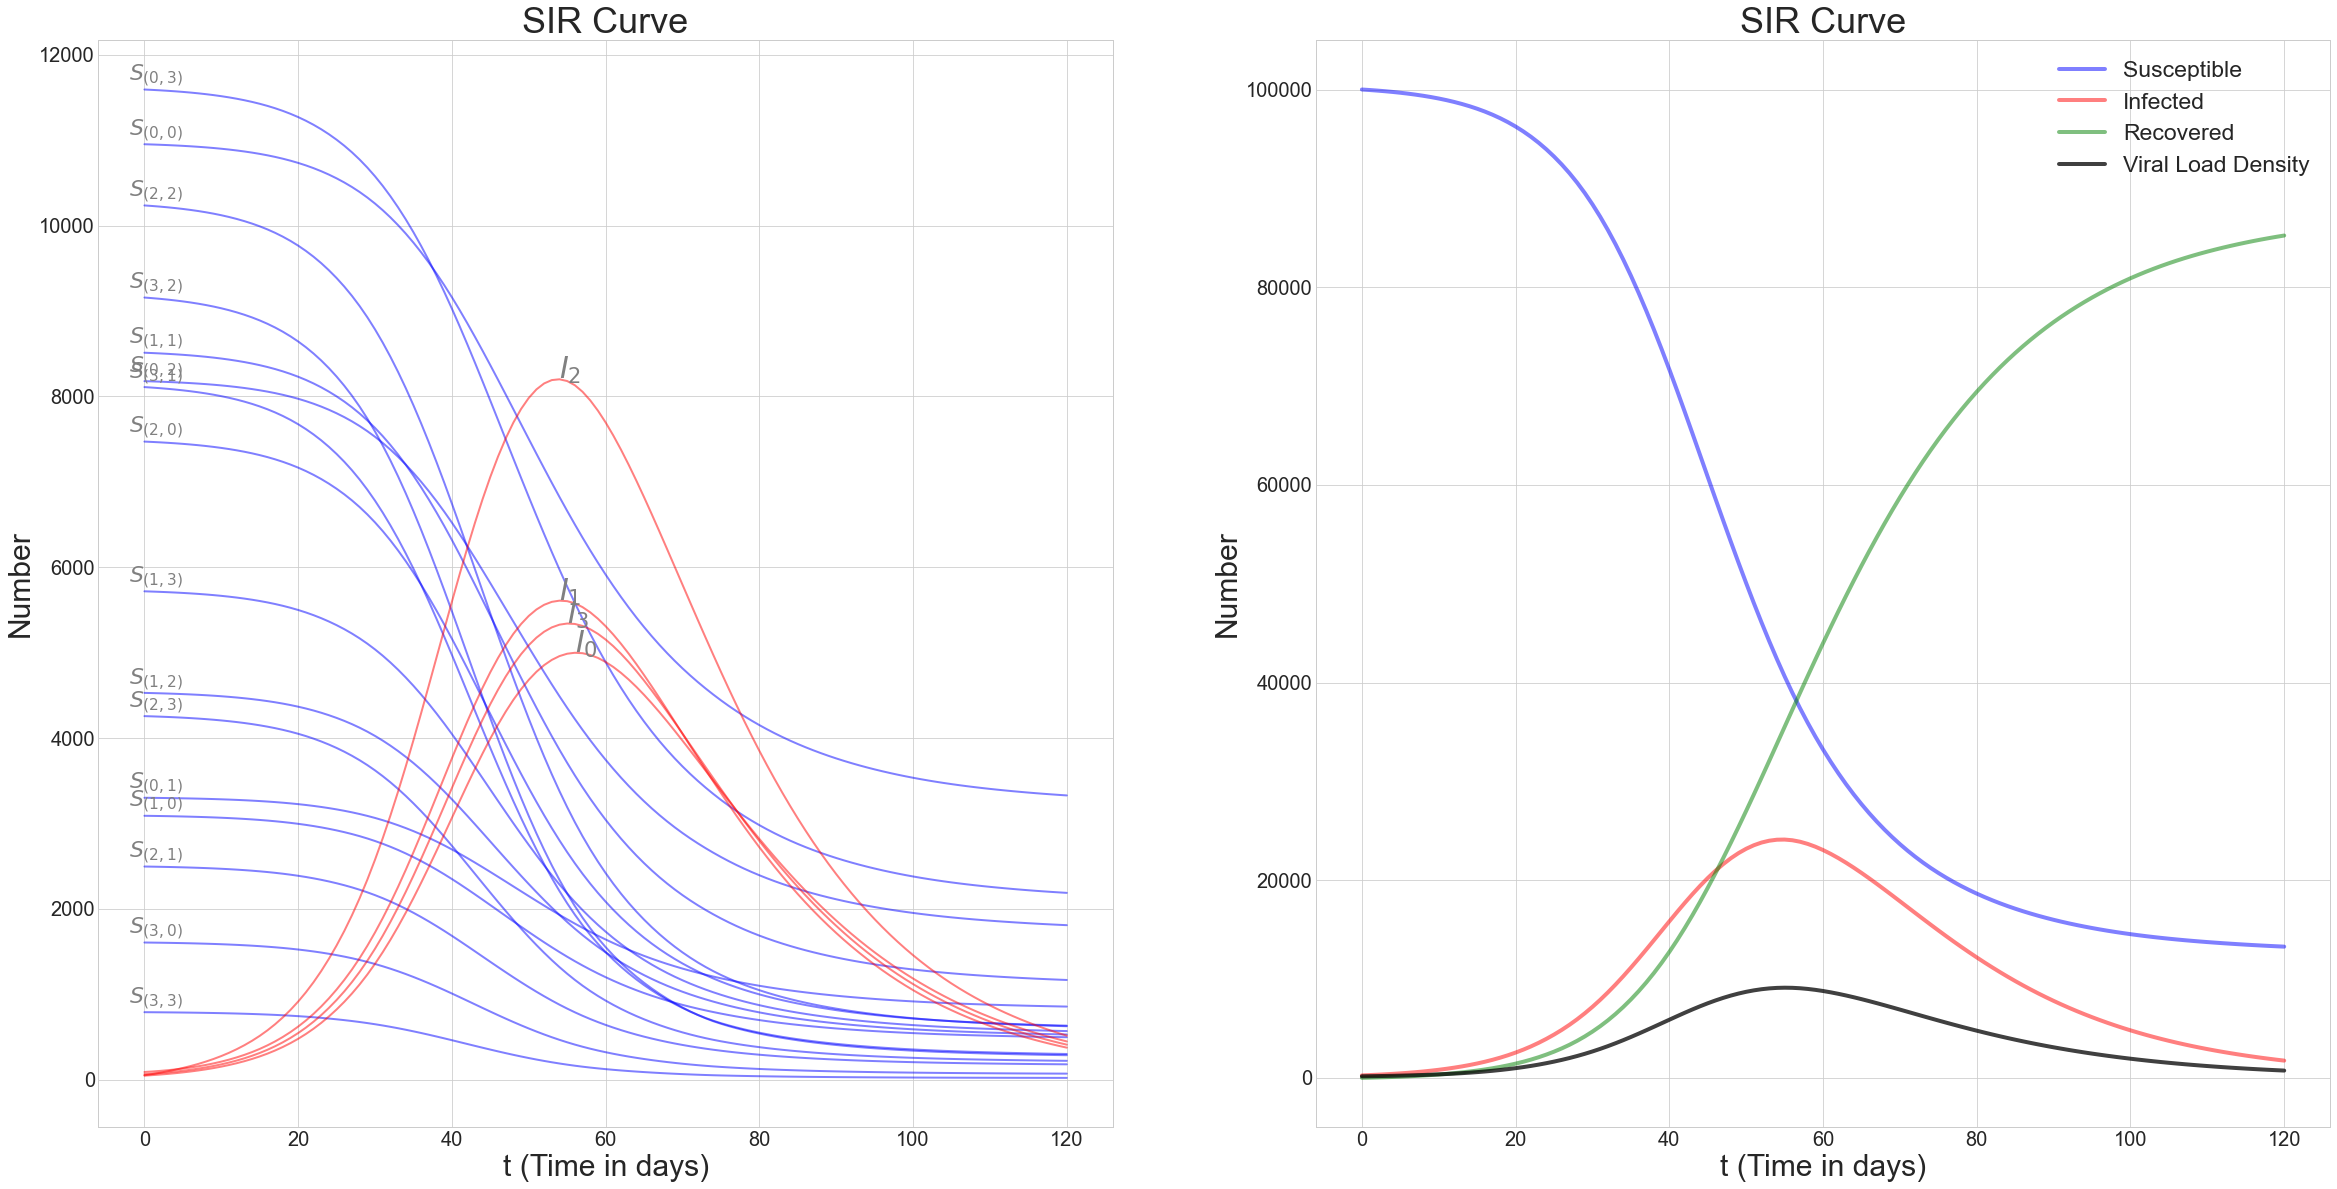

In [153]:
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=25) 
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (40,20) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
all_I = [I1,I2,I3,I4]

# Plot Susceptible vc
style = dict(size=22, color='gray')


for Svc, index in zip(all_S, product(range(4),range(4))):
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax[0].text(-2, Svc[0] + 100, f"$S_{{{index[0],index[1]}}}$", **style)

# Plot Infected vc
for c, Ic in enumerate(all_I):
    max_ind = np.where(Ic == Ic.max())[0]
    ax[0].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')
    ax[0].text(max_ind, Ic[max_ind], f"$I_{{{c}}}$", size = 30, color = 'gray')

# Plot Overall S, I, R
ax[1].plot(soln.t, np.sum(all_S, axis = 0), 'b', alpha=0.5, lw=4, label='Susceptible')
ax[1].plot(soln.t, np.sum(all_I, axis = 0),'r', alpha=0.5, lw=4, label='Infected')
ax[1].plot(soln.t, R0, 'g', alpha=0.5, lw=4, label='Recovered')
# Plot viral load density L
Lty = (I1 * L[0] + I2 * L[1] + I[3] * L[2] + I4 * L[3])
ax[1].plot(soln.t, Lty, 'black', alpha = 0.75, lw = 4, label = 'Viral Load Density')

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")
ax[1].legend(fontsize = 23)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")



3) Do the shapes of S, I, R look similar to what you expected? Which of these plots is the “curve” people refer to when they say “flatten the curve”?

4) Do you observe that some Sv,c compartments converged to zero while others converged to a positive value? Why do you think that is?

5) Print the percentages of population that never got infected for all compartments (i.e. all values of v and c).


In [156]:
v = 0
c = 0
for Svc in all_S:
    print(f"S{v}{c}: {Svc[-1]/Svc[0]}")
    if c == 3:
        v +=1
        c = 0
    c += 1

S00: 0.30385930986884385
S01: 0.25925183318555345
S02: 0.22116861930870635
S03: 0.18864642323700023
S11: 0.16086522528162292
S12: 0.13712696724770584
S13: 0.11683742143621478
S21: 0.09949073472600328
S22: 0.08465625641671017
S23: 0.07196731535123997
S31: 0.06111166046891348
S32: 0.05182332054652795
S33: 0.043875674474910344
S41: 0.037075553858456
S42: 0.03125822575595577
S43: 0.02628312563766615


6) Multiply all the βv,c values by 1/4. What happened to the S, I, R plots? Did the “curve” flatten compared to the previous case? Print the percentages of population that never got infected with these βv,c values.

[Text(0.5, 0, 't (Time in days)'),
 Text(0, 0.5, 'Number'),
 Text(0.5, 1.0, 'SIR Curve')]

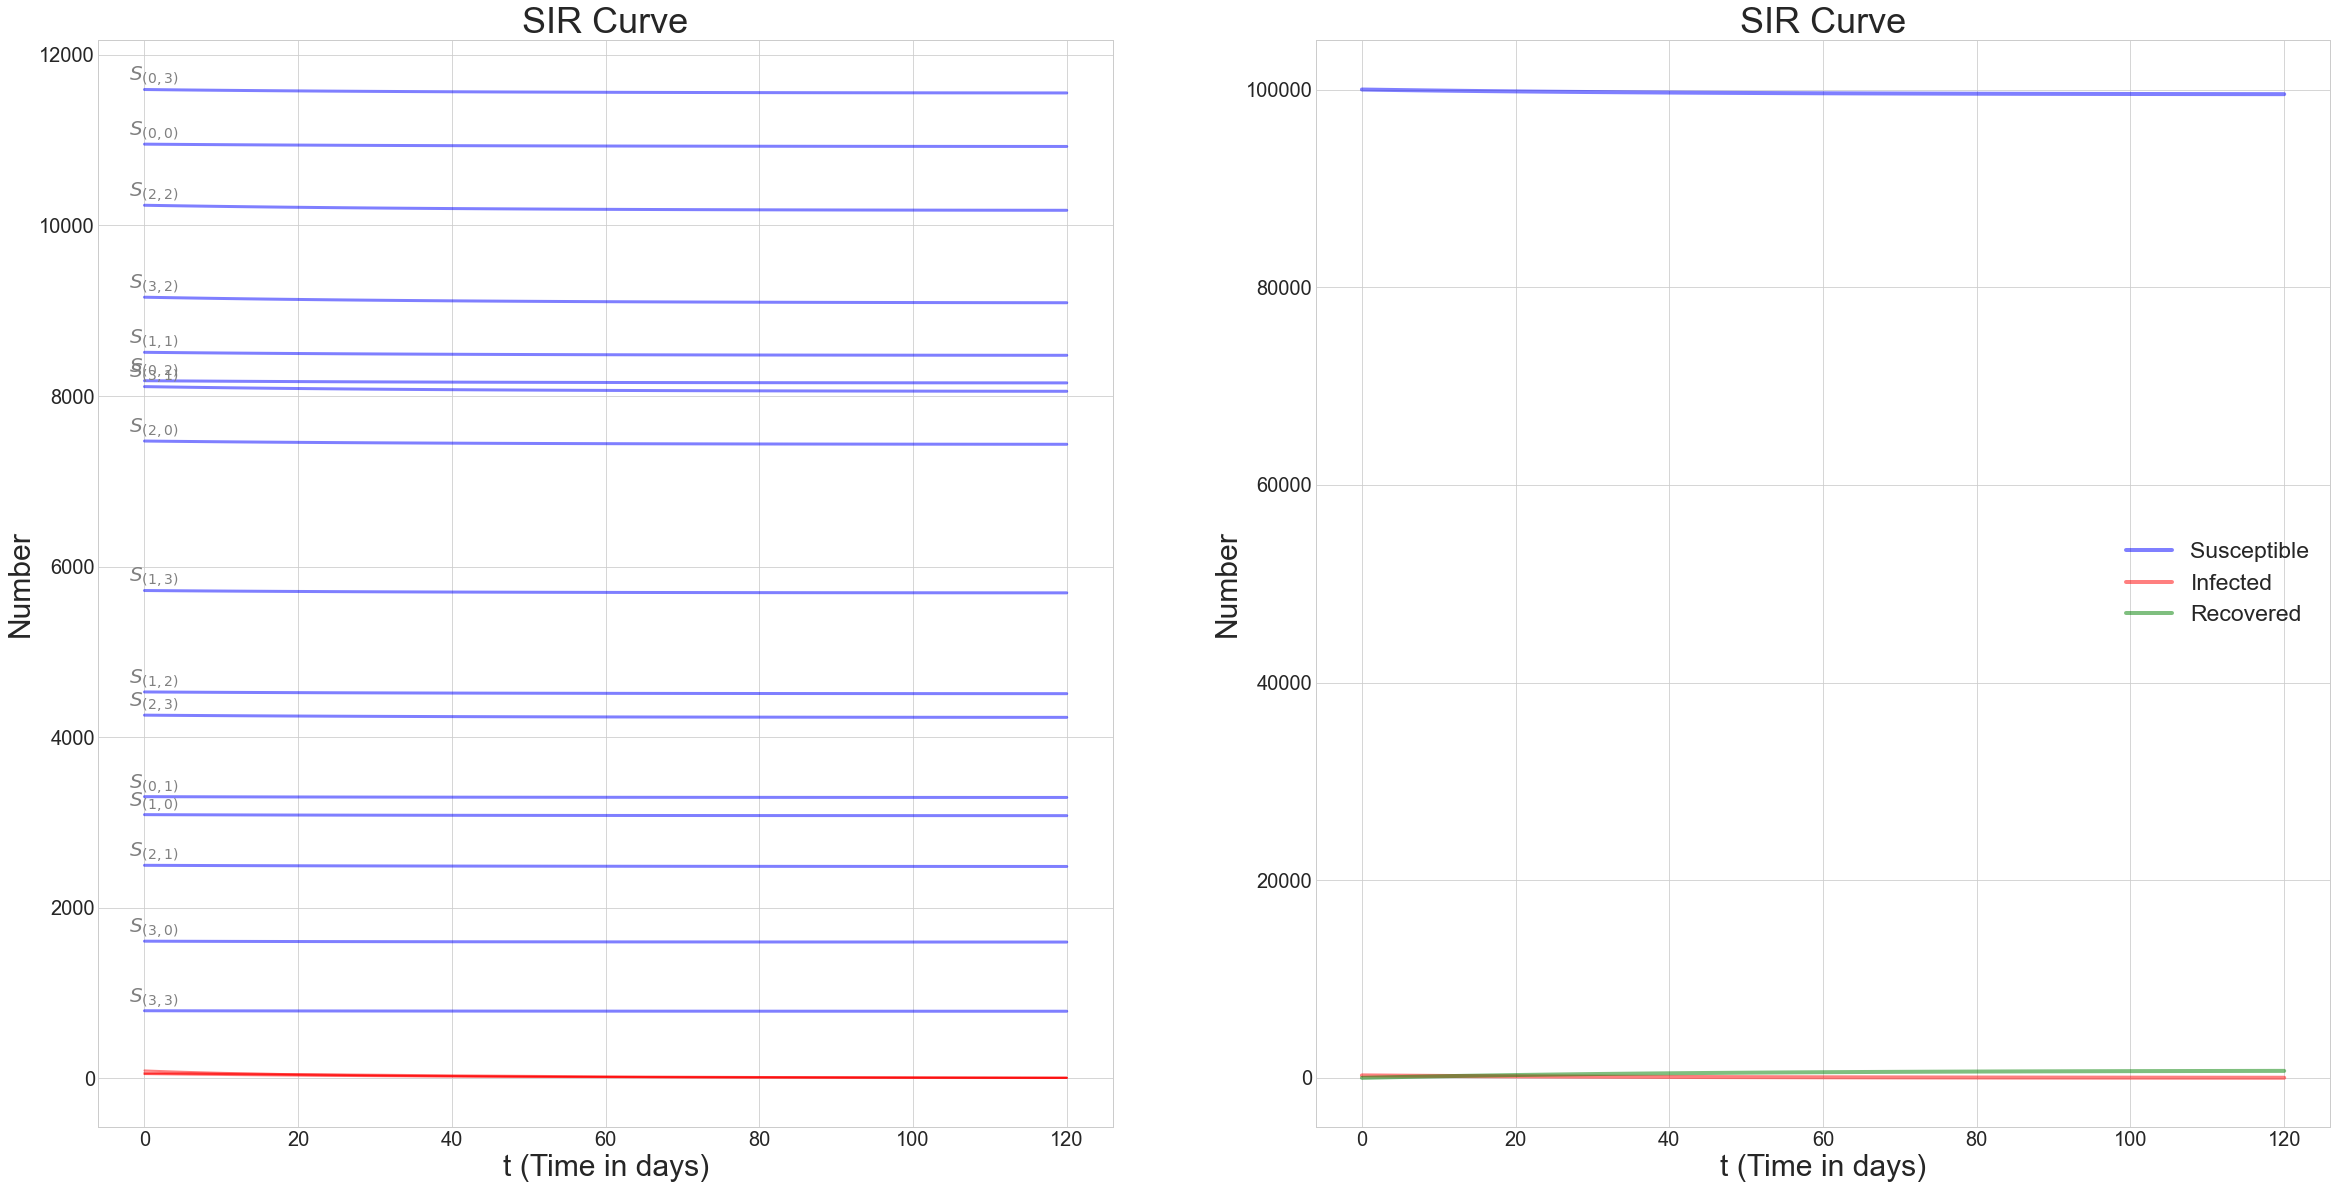

In [149]:
plt.rc('font', size=25) 
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (40,20) )
# ax[0].set(xlabel = "t (Time in days)", ylabel = "Number",
#          title = "SIR Curve")
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta/4, gamma) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
all_I = [I1,I2,I3,I4]

for Svc, index in zip(all_S, product(range(4),range(4))):
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax[0].text(-2, Svc[0] + 100, f"$S_{{{index[0],index[1]}}}$", **style)

# Plot Infected vc
for c, Ic in enumerate(all_I):
    ax[0].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')

ax[1].plot(soln.t, np.sum(all_S, axis = 0), 'b', alpha=0.5, lw=4, label='Susceptible')
ax[1].plot(soln.t, np.sum(all_I, axis = 0),'r', alpha=0.5, lw=4, label='Infected')
ax[1].plot(soln.t, R0, 'g', alpha=0.5, lw=4, label='Recovered')

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")
ax[1].legend(fontsize = 23)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")


In [59]:
v = 0
c = 0
for Svc in all_S:
    print(f"S{v}{c}: {Svc[-1]/Svc[0]}")
    if c == 3:
        v +=1
        c = 0
    c += 1

S: v = 0, c = 0: 0.9975255455045224
S: v = 0, c = 1: 0.997196081268766
S: v = 0, c = 2: 0.996866725867394
S: v = 0, c = 3: 0.9965374792644626
S: v = 1, c = 1: 0.996208341424039
S: v = 1, c = 2: 0.9958793123102025
S: v = 1, c = 3: 0.9955503918870441
S: v = 2, c = 1: 0.995221580118667
S: v = 2, c = 2: 0.9948928769691868
S: v = 2, c = 3: 0.994564282402729
S: v = 3, c = 1: 0.994235796383433
S: v = 3, c = 2: 0.9939074188754496
S: v = 3, c = 3: 0.99357914984294
S: v = 4, c = 1: 0.9932509892500797
S: v = 4, c = 2: 0.992922937061054
S: v = 4, c = 3: 0.9925949932400605


## Part 1b

In [2]:
bdata = np.load("part1b.npz")

In [3]:
bdata.files

['N', 'Lc', 'Ic_0', 'gamma', 'L_validation', 'L_test', 'betas_validation']

In [4]:
N_b = bdata['N'] # Each node has population N
L_b = bdata['Lc']
I_b = bdata['Ic_0']
gamma_b = bdata['gamma']
L_validation = bdata['L_validation']
L_test = bdata['L_test']
betas_validation = bdata['betas_validation']

In [25]:
L_b

array([0.3, 0.4, 0.7, 1. ])

In [14]:
def SIR_b(t, y, N, beta, gamma):
    
    Sv0, Sv1, Sv2, Sv3, I0, I1, I2, I3, R = y
    I = np.sum([I0,I1,I2,I3])
    
    dSv0dt = -beta[0] * Sv0 * I / N
    dSv1dt = -beta[1] * Sv1 * I / N
    dSv2dt = -beta[2] * Sv2 * I / N
    dSv3dt = -beta[3] * Sv3 * I / N
    
    dI0dt = -1 * dSv0dt - (gamma * I0)
    dI1dt = -1 * dSv1dt - (gamma * I1)
    dI2dt = -1 * dSv2dt - (gamma * I2)
    dI3dt = -1 * dSv3dt - (gamma * I3)
    
    dRdt = gamma * I
   
    return dSv0dt, dSv1dt, dSv2dt, dSv3dt,\
    dI0dt, dI1dt, dI2dt, dI3dt, dRdt

1) Using these distributions, total population sizes and observations of viral load densities L for 20 consecutive days (day 0 through day 19) for the 20 leaf nodes that are given to you, estimate the 16 parameters βv,c using grid search and MMSE on the “validation” data. In other words try to minimize MSE between Lvalidation and Lestimated. Compare the βv,c you estimated with the ground truth given in the file. This step is to make sure your code and logic works correctly.


In [31]:
# Beta Grid Search

def beta_gridsearch(beta_grid):
    '''Select what beta values you want to search for thru beta_grid
    e.g. beta_grid = np.linspace(0,1,21)'''
    pmf = [0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4]
    Lc = [0.3,0.4,0.7,1]
    gamma = 0.07142857
    beta_mmse=np.zeros((4,4))
    prev_beta_vc = np.zeros(4)
    
    # Create initial values in vulnerability group v for grid search
    for start, end, pmf_start, pmf_end, i in \
    zip(range(0,20,5), range(5,25,5), range(0,16,4), range(4,20,4), range(4)):
        
        mmse = np.inf
        pmf0c = np.array(pmf[pmf_start:pmf_end])
        Sv0, Sv1, Sv2, Sv3 = pmf0c * 50000 * 5
        I0,I1,I2,I3 = I_b[start:end].sum(axis = 0)
        R = 250000 - np.sum([I0,I1,I2,I3])
        start_time = time()
        # Grid search for optimal values of beta 
        for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
            
            # Boolean
            bigger_than_prev_beta = (betav0 >= prev_beta_vc[0]) and betav1 >=(prev_beta_vc[1])\
            and (betav2 >= prev_beta_vc[2]) and (betav3 >=prev_beta_vc[3])
            
            # Check if beta values are greater as vulnerability increases and comorbidity increases, ignore
            # ignore product of beta values if conditions not satisfied
            
            if (betav0 <= betav1 <= betav2 <= betav3) and bigger_than_prev_beta:
                # If beta values valid, solve ODE with 
                beta = [betav0, betav1, betav2, betav3]
                
                # Solve ODE
                soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                                     y0 = (Sv0, Sv1, Sv2, Sv3,
                                     I0,I1,I2,I3, R), \
                                     t_eval = np.arange(20), \
                                     args = (N_b * 5, beta, gamma))
                
                # Assign solutions from solution object
                Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, R_y = soln_obj.y
                
                # Calculate sample L and MSE
                L_pred = np.sum(np.array([I0_y * Lc[0], I1_y * Lc[1],I2_y * Lc[2],I3_y * Lc[3]]), axis = 0)
                L_true = L_validation[start:end].sum(axis=0)
                mse = mean_squared_error(L_true, L_true) 

                # If mse is lower, store new value
                if mse < mmse:
                    mmse = mse
                    beta_mmse[i,:] = beta
                    
        # Store beta mmse estimates of previous vulnerability group for checking           
        prev_beta_vc = beta_mmse[i,:]
        end_time = time()
#         print(I0_y * Lc[0], I1_y * Lc[1],I2_y * Lc[2],I3_y * Lc[3])
        print(f"Run time: {end_time - start_time:.2f} seconds")
        print(f"Estimated values are beta={beta_mmse[i,:]}")
        print(f"MMSE = {mmse}\n")
    return beta_mmse

In [20]:
beta_mmse = beta_gridsearch(np.linspace(0,1,21))

Run time: 25.50 seconds
Estimated values are beta=[0.1  0.15 0.2  0.25]
MMSE = 133.3605758476707

Run time: 20.14 seconds
Estimated values are beta=[0.15 0.25 0.35 0.45]
MMSE = 2475.079439474669

Run time: 17.59 seconds
Estimated values are beta=[0.5  0.5  0.55 0.6 ]
MMSE = 18361855.62904679

Run time: 4.20 seconds
Estimated values are beta=[0.55 0.55 0.55 0.75]
MMSE = 761488.167337408



# Individually calculating L for each node

In [32]:
# Beta Grid Search

def beta_gridsearch(beta_grid, pmf, I_b, L, prev_beta_vc):
    '''Select what beta values you want to search for thru beta_grid for FIVE NODES
    e.g. beta_grid = np.linspace(0,1,21), pmf[0:4], I_b[0:5] for first five nodes'''
    beta_mmse= None 
    mmse = np.inf
    start_time = time()

    # Grid search for optimal values of beta 
    for (betav0, betav1, betav2, betav3) in tqdm(product(beta_grid, beta_grid, beta_grid, beta_grid)):

        # Check if beta values are greater as vulnerability increases and comorbidity increases, ignore
        # ignore product of beta values if conditions not satisfied
         
        # Boolean
        bigger_than_prev_beta = (betav0 >= prev_beta_vc[0]) and betav1 >=(prev_beta_vc[1])\
        and (betav2 >= prev_beta_vc[2]) and (betav3 >=prev_beta_vc[3])
        
        if (betav0 <= betav1 <= betav2 <= betav3) and bigger_than_prev_beta:
            # If beta values valid, solve ODE with 
            beta = [betav0, betav1, betav2, betav3]
            nodes = 5
            
            L_array = np.empty((5,20))
            for n in range(nodes):
                Sv0, Sv1, Sv2, Sv3 = pmf * 50000
                I0,I1,I2,I3 = I_b[n]
#                 print(I0, I1,I2,I3)
                I_total = np.sum([I0,I1,I2,I3])
                R = 50000 - I_total
#                 print(I_five_nodes)
                # Solve ODE
                soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                                     y0 = (Sv0, Sv1, Sv2, Sv3,
                                     I0,I1,I2,I3, R), \
                                     t_eval = np.arange(20), dense_output = True, \
                                     args = (50000, beta, gamma_b))
                # Assign solutions from solution object
                Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, R_y = soln_obj.y
                # Calculate sample L and MSE
                L_array[n] = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
                
            mse = mean_squared_error(L_array.sum(axis=0), L.sum(axis = 0)) 
            
#             print(L_array.sum(axis=0), L.sum(axis = 0))
#             print(mse)

            # If mse is lower, store new value
            if mse < mmse:
                mmse = mse
                beta_mmse = beta
                print(L_array.sum(axis=0), L.sum(axis = 0))
    
    # Store beta mmse estimates of previous vulnerability group for checking           
    end_time = time()
    print(f"Run time: {end_time - start_time:.2f} seconds")
    print(f"Estimated values are beta={beta_mmse}")
    print(f"MMSE = {mmse}\n")
    return beta_mmse

Vulnerability 1

In [33]:
pmf = np.array([0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4])
beta_mmse_1 = beta_gridsearch(np.linspace(0,1,21), pmf[0:4], I_b[0:5], L_validation[0:5], np.zeros(4))

10it [00:00, 91.60it/s]

[643.5        599.13888988 557.83592947 519.34059112 483.44233812
 449.99551775 418.85775702 389.88993804 362.95619796 337.92392904
 314.66377856 293.04964891 272.95869754 254.27133696 236.87123476
 220.6453136  205.4837512  191.31901081 178.13001665 165.85024846] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[643.5        604.1133492  567.12124111 532.36134516 499.68952105
 468.99577133 440.1732874  413.11838576 387.7305079  363.91222041
 341.56921491 320.61030807 300.94744162 282.49568232 265.173222
 248.90137754 233.60615677 219.22269915 205.7158484  193.03680797] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 13

32it [00:00, 98.01it/s]

[ 643.5         692.41365435  739.28963195  784.27250024  827.46038826
  868.93294037  908.76678154  947.03551724  983.80973357 1019.15699716
 1053.14185522 1085.8258355  1117.26744635 1147.52217667 1176.6409625
 1204.66746175 1231.62905654 1257.53441052 1282.40661077 1306.26813984] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         697.8335276   750.30623958  801.0579269   850.17970243
  897.74412012  943.82008293  988.47284285 1031.76400086 1073.75150694
 1114.48966011 1154.02910838 1192.41684877 1229.69622732 1265.90556019
 1301.07503204 1335.21821943 1368.32925384 1400.41655574 1431.48769325] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 111

81it [00:00, 111.47it/s]

[ 643.5         705.65860689  766.68056873  826.70197777  885.81079749
  944.07440264 1001.55444873 1058.30687203 1114.38188958 1169.82399918
 1224.67197938 1278.95888951 1332.71206963 1385.9531406  1438.69737889
 1490.94954692 1542.7020559  1593.91770157 1644.56564888 1694.61736845] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         704.10940552  763.68121285  822.35117043  880.20932794
  937.32484924  993.76150395 1049.57766742 1104.82632072 1159.55505065
 1213.80604977 1267.61611633 1321.01665435 1374.03367356 1426.6873935
 1478.98796115 1530.93553611 1582.50088012 1633.65467865 1684.37338632] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 111

125it [00:01, 120.47it/s]

[ 643.5         708.04512767  771.96607745  835.40300032  898.45241127
  961.18960151 1023.68296827 1085.99401477 1148.17735026 1210.28068997
 1272.34485517 1334.40377311 1396.48447708 1458.60710634 1520.78466694
 1583.01848632 1645.2991245  1707.58590308 1769.83138951 1831.99384559] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         706.48906321  768.93914455  830.98957088  892.7385485
  954.26322433 1015.63428744 1076.91596906 1138.16604254 1199.4358234
 1260.7701693  1322.20748006 1383.77969763 1445.51230612 1507.42423248
 1569.52353166 1631.80870063 1694.2490669  1756.80199091 1819.43243166] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115

160it [00:01, 141.33it/s]

[ 643.5         704.93088512  765.90329361  826.55486417  886.9845366
  947.27048557 1007.4848376  1067.69367109 1127.95701629 1188.32885532
 1248.85712217 1309.58370267 1370.54443453 1431.76910732 1493.2814459
 1555.09529036 1617.21545205 1679.62008878 1742.27123805 1805.13978375] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         703.37059675  762.85855056  822.09898672  881.19060987
  940.21180999  999.23530239 1058.32812768 1117.5516518  1176.96156602
 1236.60788694 1296.53495645 1356.78144178 1417.3803355  1478.35895547
 1539.73590859 1601.52072436 1663.69882969 1726.23655214 1789.10984956] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115

216it [00:01, 159.61it/s]

[ 643.5         701.80820152  759.80494049  817.62204522  875.35701964
  933.08767014  990.88645787 1048.82049874 1106.95156344 1165.33607739
 1224.02512082 1283.06442869 1342.49439074 1402.35005147 1462.66111014
 1523.44968789 1584.72863948 1646.48880125 1708.70016238 1771.34280198] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         700.24370282  756.74248812  813.12413901  869.48401775
  925.89856047  982.43913781 1039.17205491 1096.15855147 1153.45480169
 1211.11191431 1269.17593257 1327.68783425 1386.68353166 1446.1938716
 1506.24312263 1566.84610928 1627.99724055 1689.66920896 1751.84518491] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 111

602it [00:03, 168.25it/s]

[ 643.5         701.02934693  758.823045    817.01312242  875.70561653
  934.98850641  994.94435594 1055.65031382 1117.17811359 1179.59407357
 1242.95909693 1307.32867165 1372.75287053 1439.27635119 1506.93835606
 1575.77100825 1645.79720129 1717.02918279 1789.44972246 1863.03572409] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         699.46262117  755.75224199  812.49783009  869.80437422
  927.75948332  986.44581894 1045.94109524 1106.31807894 1167.64458939
 1229.98349853 1293.39273089 1357.92526361 1423.62912642 1490.54740164
 1558.71716725 1628.16618115 1698.91462357 1770.95237338 1844.26292023] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 11

644it [00:03, 175.93it/s]

[ 643.5         697.89378273  752.67250912  807.96121712  863.86276732
  920.46352358  977.84528109 1036.08526634 1095.25613716 1155.42598268
 1216.65832339 1279.01211106 1342.5417288  1407.29699105 1473.32314356
 1540.66032742 1609.33957446 1679.38595648 1750.79463718 1823.55384104] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         696.32283506  749.58387193  803.40337743  857.88106058
  913.10117898  969.14370652 1026.08433334 1083.99446589 1142.94122689
 1202.98745535 1264.19170656 1326.60825209 1390.2870798  1455.27389382
 1521.60994251 1589.32796661 1658.45489684 1728.98935703 1800.9221799 ] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 11

1062it [00:05, 195.33it/s]

[ 643.5         695.52782622  748.54147737  802.66571482  858.01330635
  914.68726624  972.7868949  1032.40777884 1093.64179064 1156.57708898
 1221.29811865 1287.88561052 1356.41658156 1426.96433484 1499.59845952
 1574.38470251 1651.3813758  1730.64061487 1812.19187436 1896.04962517] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         693.95251543  745.43535543  798.06852723  851.96152111
  907.21507293  963.92657144 1022.19005838 1082.09622842 1143.73242918
 1207.18266124 1272.52757812 1339.84448629 1409.20734517 1480.68676712
 1554.35001727 1630.25829919 1708.46649586 1789.00787764 1871.90185631] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 11

1092it [00:05, 181.35it/s]

[ 643.5         692.37508968  742.32026455  793.44983158  845.86901533
  899.67532425  954.96314035 1011.82371926 1070.34519019 1130.61255599
 1192.70769306 1256.70935144 1322.69315476 1390.73160023 1460.89405869
 1533.24677457 1607.85140404 1684.76249748 1764.01336405 1845.62588947] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]


1500it [00:06, 217.19it/s]

[ 643.5         689.98422872  738.0917745   787.94038418  839.64876308
  893.33453388  949.11373608 1007.10082608 1067.40867712 1130.14857933
 1195.43023969 1263.36178204 1334.04974711 1407.59909247 1484.11319258
 1563.69383875 1646.44060704 1732.44173366 1821.77804128 1914.51650183] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]


1858it [00:07, 396.97it/s]

[ 643.5         686.8178067   731.81512514  778.59877496  827.27827061
  877.96363203  930.76400704  985.78767137 1043.14202863 1102.9336103
 1165.26807579 1230.25021235 1297.98393516 1368.57228726 1442.11743959
 1518.72069099 1598.47868911 1681.48063509 1767.81400019 1857.5520048 ] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]


2324it [00:09, 418.76it/s]

[ 643.5         681.22947098  721.18612065  763.47129068  808.19978526
  855.49430358  905.47914588  958.28021345 1014.02500867 1072.84263493
 1134.86379669 1200.22079948 1269.04754986 1341.47955547 1417.65392498
 1497.70927462 1581.78388419 1670.01407299 1762.53336203 1859.46853323] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]


10642it [00:21, 490.85it/s]

[ 643.5         684.92954313  728.53463605  774.43184478  822.7480845
  873.61957715  927.18397363  983.58034449 1042.94917997 1105.43238998
 1171.17330412 1240.31667165 1313.00866152 1389.39686233 1469.63028239
 1553.85934444 1642.23491592 1734.90596073 1832.01895855 1933.71899419] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]
[ 643.5         683.34721085  725.40066694  769.77328771  816.58831197
  865.97970015  918.08371648  973.03889822 1030.98605568 1092.06827219
 1156.43090415 1224.22158098 1295.59020516 1370.6889522  1449.67227064
 1532.69688209 1619.92145073 1711.50477081 1807.60454626 1908.37797794] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 111

11116it [00:23, 412.46it/s]

[ 643.5         679.32416291  717.84069244  759.16719593  803.43885362
  850.81004047  901.44081532  955.49688521 1013.14960542 1074.57597947
 1139.95865912 1209.48594433 1283.35178333 1361.75577256 1444.90315671
 1533.0048287  1626.27881851 1724.94849102 1829.23779946 1939.37343107] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]


19449it [00:34, 2560.63it/s]

[ 643.5         675.81011977  711.25462479  749.96591844  792.10161197
  837.83810267  887.36284517  940.87435142  998.58219073 1060.70698973
 1127.48043237 1199.14525998 1275.95527118 1358.17532195 1446.0813256
 1539.96068278 1640.11691465 1746.87252272 1860.558731   1981.50887602] [ 644.96041739  677.40633315  712.47883641  747.22024502  791.02074006
  839.67998379  882.59217402  938.52617005  998.18088246 1051.31798693
 1115.11323854 1198.5226907  1266.89146925 1347.48506605 1430.19972307
 1527.21101358 1617.5185973  1734.65171415 1834.42655929 1969.08182716]


194481it [02:26, 1323.74it/s] 

Run time: 146.92 seconds
Estimated values are beta=[0.1, 0.15000000000000002, 0.2, 0.25]
MMSE = 119.83845953659238



In [ ]:
beta_mmse_2 = beta_gridsearch(np.linspace(0,1,21), pmf[4:8], I_b[5:10], L_validation[5:10], [0.1,0.15,0.2,0.25])

In [34]:
beta_mmse_3 = beta_gridsearch(np.linspace(0,1,21), pmf[8:12], I_b[10:15], L_validation[10:15], [0.2,0.25,0.3,0.4])

39389it [00:00, 351611.19it/s]

[  607.9          756.57755847   937.54140872  1157.76021893
  1425.6521668   1751.41255311  2147.03017663  2626.15852206
  3203.89913272  3900.67489171  4739.11014686  5742.59428294
  6935.28172167  8342.09192171  9987.86363224 11896.18170187
 14088.37415275 16573.24541357 19344.94997871 22382.99240826] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          768.83068415   966.37509726  1208.86226118
  1506.45652523  1871.52978791  2318.67773084  2864.36987613
  3527.80626465  4334.53520812  5311.65968684  6487.02606136
  7889.22407245  9547.28567888 11487.4431094  13737.1521145
 16314.03820536 19215.39786153 22417.89881518 25877.58005116] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.

[  607.9          928.90905166  1373.50322715  1989.02586514
  2839.31127714  4004.59113394  5584.70424634  7712.47827546
 10513.61445247 14097.42022606 18543.34285943 23853.82622336
 29887.74520746 36360.0633515  42848.84500102 48906.73651638
 54169.5697114  58384.06676689 61450.26937962 63409.79221118] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          942.92826469  1411.28156923  2065.65763933
  2977.43993021  4236.05964144  5955.24503926  8281.21085069
 11347.01629288 15262.9028174  20097.19704192 25805.7157092
 32184.85367829 38872.6230944  45380.75075289 51276.20737785
 56208.47966891 59986.50289751 62591.14656165 64112.05004496] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.

[  607.9         1026.41828683  1660.21804958  2617.58577503
  4052.86837083  6166.60270244  9239.44525801 13544.25337118
 19292.27321581 26545.22166568 35019.8068104  44030.36998288
 52570.59224578 59800.67462486 65213.24502051 68660.82305735
 70354.43870946 70630.88451906 69847.92393549 68319.72725267] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9         1041.58637957  1704.55477017  2715.16061503
  4242.62112092  6508.29002584  9818.76785329 14460.26665719
 20641.01602247 28369.33147026 37249.98308666 46460.38760737
 54913.86967804 61816.14944861 66737.07116653 69652.02467505
 70873.31067239 70761.79642065 69692.02555017 67955.95526508] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421

[  607.9         1022.63126813  1658.21415229  2629.42560427
  4101.97514344  6296.5313571   9522.11844778 14086.29742025
 20236.81120791 28065.99614714 37259.45315889 47006.54658922
 56178.52666844 63845.94616877 69444.20573219 72844.76016611
 74314.15556138 74242.65927059 73050.8721355  71080.13176152] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9         1037.85577119  1702.96094241  2728.58134634
  4296.24531197  6649.71847651 10125.88781048 15048.60263182
 21664.26973107 30006.22667107 39631.19763982 49570.16446479
 58626.21464799 65909.74148394 70955.45088959 73781.70799178
 74743.99443127 74273.43642784 72787.61759191 70611.87985052] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421

[  607.9         1011.18982429  1633.65672218  2591.30934824
  4053.20646854  6248.71626304  9500.00967781 14138.98205555
 20446.60576866 28564.98147156 38188.08897691 48455.56319167
 58172.77770507 66294.04634888 72174.93196929 75658.50258748
 77027.91480704 76723.736547   75215.64923096 72888.31513849] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9         1007.38492004  1624.29936399  2573.84675135
  4024.16944215  6203.95928141  9435.09012285 14052.10402645
 20340.98789024 28458.38010544 38112.2719856  48444.92907632
 58250.73298764 66464.31232167 72422.18478131 75943.07434185
 77310.76923118 76978.32782691 75427.79886324 73054.9090673 ] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421

50564it [00:20, 238.33it/s]   

[  607.9         1005.48343622  1619.64267392  2565.22649246
  4010.21868356  6183.21650084  9407.22321686 14020.90914119
 20317.47319698 28467.65029626 38194.7091158  48650.0488851
 58627.76498015 67033.91273074 73175.49355692 76850.17367397
 78326.85461587 78055.8680997  76525.40459919 74136.60940065] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9         1001.67176901  1610.23514085  2547.56653466
  3980.5364836   6136.62999132  9337.65542055 13923.07955261
 20188.62381599 28314.94483318 38037.23224037 48513.69771866
 58537.9487165  67006.29795392 73212.731329   76935.55963057
 78438.69022945 78176.03623509 76640.8493184  74241.73897891] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.

50938it [00:21, 305.19it/s]

[  607.9          994.14461676  1588.30183396  2499.26234402
  3886.1121354   5964.89569426  9042.35520788 13446.59268806
 19469.676994   27309.3791262  36763.30558174 47080.9231623
 57122.4855997  65779.79680187 72297.53847785 76384.82728326
 78228.7517869  78245.66037941 76916.20146212 74655.67716846] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          990.34877513  1578.98935385  2481.92297167
  3857.3265078   5920.52705257  8977.86026637 13359.72679846
 19362.89690731 27198.97506467 36680.8000626  47063.20109754
 57199.42020737 65959.52404503 72567.15695236 76705.98838932
 78555.04879476 78546.80649055 77170.859896   74858.53005865] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.

51040it [00:22, 221.93it/s]

[  607.9          986.54626241  1569.62790421  2464.39288959
  3827.92135345  5874.41278826  8908.94161418 13262.40595995
 19233.79330429 27043.64421004 36516.71646825 46915.98799723
 57097.1773221  65920.579793   72597.02150918 76792.06077851
 78673.41286577 78680.31925387 77301.67190023 74979.00353649] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9         1001.58846762  1613.45335481  2560.96300859
  4016.8247933   6218.57508042  9501.45918622 14219.60585062
 20682.58537477 29074.00648216 39087.42657655 49810.15455089
 59976.21780244 68449.04503472 74531.03527592 78038.83392966
 79292.59296219 78783.3757106  77025.67872619 74436.11914757] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421

51401it [00:22, 299.42it/s]

[  607.9          990.2290252   1581.9718309   2494.47757092
  3891.24562168  5996.49527018  9128.40659493 13629.07712164
 19805.2487476  27867.20694986 37585.95635479 48151.77174709
 58364.13907175 67074.99141731 73527.10155934 77445.50590354
 79066.44510534 78850.46643782 77303.24567523 74855.01855584] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          986.41906434  1572.57760776  2476.87226407
  3861.75218439  5950.4564919   9060.27618639 13534.78470084
 19684.39975571 27731.72232699 37461.35946676 48071.0275985
 58357.33551469 67155.21376315 73689.09126083 77661.08831597
 79300.29906415 79078.53964262 77505.13903191 75024.28808949] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.

51867it [00:23, 360.64it/s]

[  607.9          986.28347835  1575.49174682  2489.27220834
  3895.38296792  6025.98855513  9209.97892246 13801.84398716
 20121.39723844 28385.1837807  38331.20023425 49091.26984988
 59411.59594262 68120.4903957  74469.81332047 78209.46330675
 79627.59213425 79217.6583853  77499.38686899 74911.88389785] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          982.45933817  1566.01499769  2471.39646964
  3865.16383421  5978.21431451  9138.02399018 13699.61009819
 19985.28297842 28221.79591044 38159.21259443 48939.01616486
 59309.53185115 68087.27718595 74509.41324022 78306.08798185
 79758.05329267 79364.51131693 77643.22629467 75044.41601891] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421

59455it [00:32, 618.34it/s] 

[  607.9          984.64758589  1564.9778304   2455.76266035
  3813.8197831   5853.05111695  8879.09907696 13225.71235602
 19197.17092845 27024.6555006  36546.69370161 47035.11054729
 57347.38128387 66321.313175   73141.34136517 77452.22549262
 79409.44843484 79448.40282675 78067.2446598  75713.9882037 ] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          995.85371759  1599.26008393  2534.24896472
  3971.99316326  6148.27453005  9397.36390587 14076.51909493
 20502.18582623 28878.31914913 38922.84888271 49740.7499043
 60069.56161202 68740.84610608 75021.16684086 78691.54378203
 80054.08752402 79599.09348514 77850.03001874 75234.92661341] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.

60234it [00:34, 528.20it/s]

[  607.9          988.32791059  1577.31693148  2485.8602613
  3877.28165868  5975.73251192  9100.48491475 13597.82223683
 19781.52865603 27876.62327186 37669.91449768 48360.41342495
 58745.02766981 67641.75981917 74260.09053479 78300.71443623
 79987.90929012 79784.22061898 78207.95382366 75700.11735265] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          984.51791885  1567.92230906  2468.2531169
  3847.78190328  5929.67191582  9032.30549649 13503.43274135
 19660.49284426 27741.00670719 37545.6595581  48281.02283037
 58741.10526504 67726.39225895 74427.40166424 78520.88314081
 80224.61497994 80012.06030125 78407.34240745 75865.29632674] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8

60791it [00:35, 438.62it/s]

[  607.9          976.56326953  1554.63301973  2456.88753429
  3853.82425478  5984.07378468  9186.68252171 13833.08277567
 20266.26766741 28732.93488452 38962.64388839 50050.63694244
 60688.50451511 69637.05191074 76110.52816818 79844.49458151
 81164.41491519 80598.42389278 78689.83474832 75905.53652421] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]


68075it [00:39, 2272.73it/s]

[  607.9          982.61195328  1563.22735859  2459.46750471
  3833.23745812  5907.16976789  8999.84473438 13461.07062444
 19611.89417105 27698.46842744 37533.01413935 48329.60685024
 58883.51757336 67976.01191663 74777.44445799 78948.75959627
 80698.54694434 80499.83259185 78884.20051109 76312.55128109] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          978.79525599  1553.78319977  2441.66636305
  3803.10366734  5859.30314114  8927.05686652 13355.68846271
 19467.17772967 27514.72539603 37321.16253989 48110.9625024
 58687.25788399 67826.80695032 74690.04054051 78921.7352563
 80718.99513719 80554.93510552 78958.55261968 76396.94700295] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8

69286it [00:44, 673.30it/s] 

[  607.9          967.52782215  1522.8128668   2376.78054023
  3681.39958326  5645.57042287  8569.67014838 12791.29619817
 18629.34431975 26358.74026928 35877.67566621 46511.86786329
 57141.35374358 66536.19669555 73795.05915683 78471.25189915
 80652.06364322 80788.88513515 79392.04942092 76950.90481445] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          982.47142436  1566.13109503  2471.89117717
  3867.14239021  5983.89765074  9153.44342397 13739.18948882
 20075.40154785 28410.62935741 38514.53464267 49534.85767906
 60203.71552199 69273.50699574 75927.97153054 79868.32273759
 81366.75333644 80930.74218923 79112.04681489 76374.86738979] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421

70141it [00:47, 528.80it/s]

[  607.9          959.49920645  1509.07318167  2363.88309176
  3683.39302071  5690.38009165  8704.26946347 13084.06272849
 19171.44077705 27253.64196948 37163.37513719 48125.31311185
 58917.84627863 68267.74505383 75300.50289606 79621.25408384
 81428.10137348 81231.26492315 79557.10497683 76899.9087668 ] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]


77796it [00:50, 2448.95it/s]

[  607.9          965.4380846   1520.75802576  2379.51857665
  3698.33271723  5693.98530493  8678.45162611 13002.95611811
 19000.20811961 26955.07046457 36735.81429019 47613.29627472
 58407.1804218  67844.71412338 75024.36795382 79522.5699916
 81487.58850019 81403.53770261 79808.10644023 77197.14252772] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          961.62308077  1511.32704004  2361.77129684
  3668.38480883  5646.65468652  8607.07252559 12901.03947177
 18863.30597668 26788.20871366 36556.4076882  47449.96085022
 58294.44981567 67805.11350369 75065.19317114 79631.1693
 81635.10961389 81572.75908589 79975.92322206 77351.0468039 ] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477

79126it [00:55, 784.22it/s] 

[  607.9          961.42030503  1513.88797256  2373.12927046
  3699.649193    5717.52658856  8748.91491698 13157.06772493
 19288.26974706 27436.49468872 37438.24917804 48512.57075193
 59420.78881892 68861.06269142 75939.62956227 80255.37231711
 82013.88230113 81737.86131899 79974.11493236 77227.22763322] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          957.59112194  1504.37435227  2355.11057611
  3668.96725344  5668.42997651  8673.60127131 13046.8464304
 19135.05101447 27238.90748339 37205.21922875 48265.82550057
 59192.838258   68679.73085658 75823.18742838 80206.34975251
 82019.88545908 81789.69854979 80054.08999652 77321.10974972] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.

87523it [01:00, 2414.09it/s]

[  607.9          959.50746942  1509.15037754  2364.19363294
  3684.65970858  5693.89065479  8713.79554733 13108.87460985
 19227.10788261 27369.3673686  37381.86453265 48489.87657695
 59455.70892881 68962.32389479 76101.67615576 80461.00933539
 82238.31116055 81961.50709776 80182.48193409 77411.82959336] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]
[  607.9          955.67827457  1499.63657832  2346.17427363
  3653.97541024  5644.78490969  8638.46075793 12998.59890347
 19073.74867821 27171.58607109 37148.67338823 48243.03352289
 59228.04452437 68781.79825326 75986.58571078 80413.78977876
 82245.81475233 82014.76956948 80263.76278978 77506.45971968] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421

97246it [01:08, 2169.22it/s]

[  607.9          953.53661593  1497.33614627  2348.27124404
  3669.55824016  5690.73503462  8742.82274628 13201.84955872
 19428.68362277 27733.53808645 37934.35783355 49211.22536453
 60274.13668349 69782.17488441 76834.729849   81040.70781427
 82650.16185964 82225.13875586 80317.68622579 77441.87378317] [  606.34375814   953.330026    1490.46877591  2330.36964487
  3574.94667753  5421.8477717   8209.47461995 12258.00637291
 18019.54708278 25593.73801221 35076.25397275 46550.20351161
 58646.1776274  69854.03826046 79584.73406786 85905.30796659
 89374.87313487 90469.50912555 89525.84430008 88110.44548302]


194481it [01:31, 2116.79it/s] 

Run time: 91.88 seconds
Estimated values are beta=[0.5, 0.5, 0.55, 0.6000000000000001]
MMSE = 18437669.08767284



In [167]:
beta_mmse_4 = beta_gridsearch(np.linspace(0,1,21), pmf[12:16], I_b[15:20], L_validation[15:20], [0.35,0.45,0.5,0.6])

194481it [02:27, 1315.42it/s] 

Run time: 147.85 seconds
Estimated values are beta=[0.1, 0.15000000000000002, 0.2, 0.25]
MMSE = 119.83845953659238



In [16]:
betas_validation

array([[0.1 , 0.15, 0.2 , 0.25],
       [0.2 , 0.25, 0.3 , 0.4 ],
       [0.35, 0.45, 0.5 , 0.6 ],
       [0.4 , 0.5 , 0.6 , 0.8 ]])

# Debugging

PMF of vulnerability 0: [0.4 0.3 0.2 0.1]

Sv0 = 100000.0, Sv1 = 75000.0, Sv2 = 50000.0, Sv3 = 25000.0

Infected population of first five nodes: Row = node, Column = comorbidity [[47 90 51 65]
 [82 31 64 86]
 [30 66 39 47]
 [59 26 77 38]
 [20 63 70 15]]

Infected population of first five nodes summed by comorbidity: (233, 202, 317, 194)

[ 233.          297.16184655  372.95190965  462.71245613  569.17976963
  695.66840322  846.0948577  1024.97758167 1237.38835762 1488.92704625
 1787.09097244 2140.24223541 2557.34950281 3047.98801072 3622.33956358
 4291.1925343  5065.85906694 5957.52653332 6976.00220494 8128.73812129]
[ 202.          263.27698604  335.35506796  420.42142716  521.03463651
  640.2813147   781.79532449  949.75777268 1148.84228155 1384.14707983
 1662.63193342 1991.95785126 2380.20055345 2835.85047118 3367.81274683
 3985.40723385 4698.26363069 5515.52302404 6444.65694068 7490.50880948]
[ 317.          355.30242454  402.96638289  461.67906141  533.43122707
  620.62808358  726

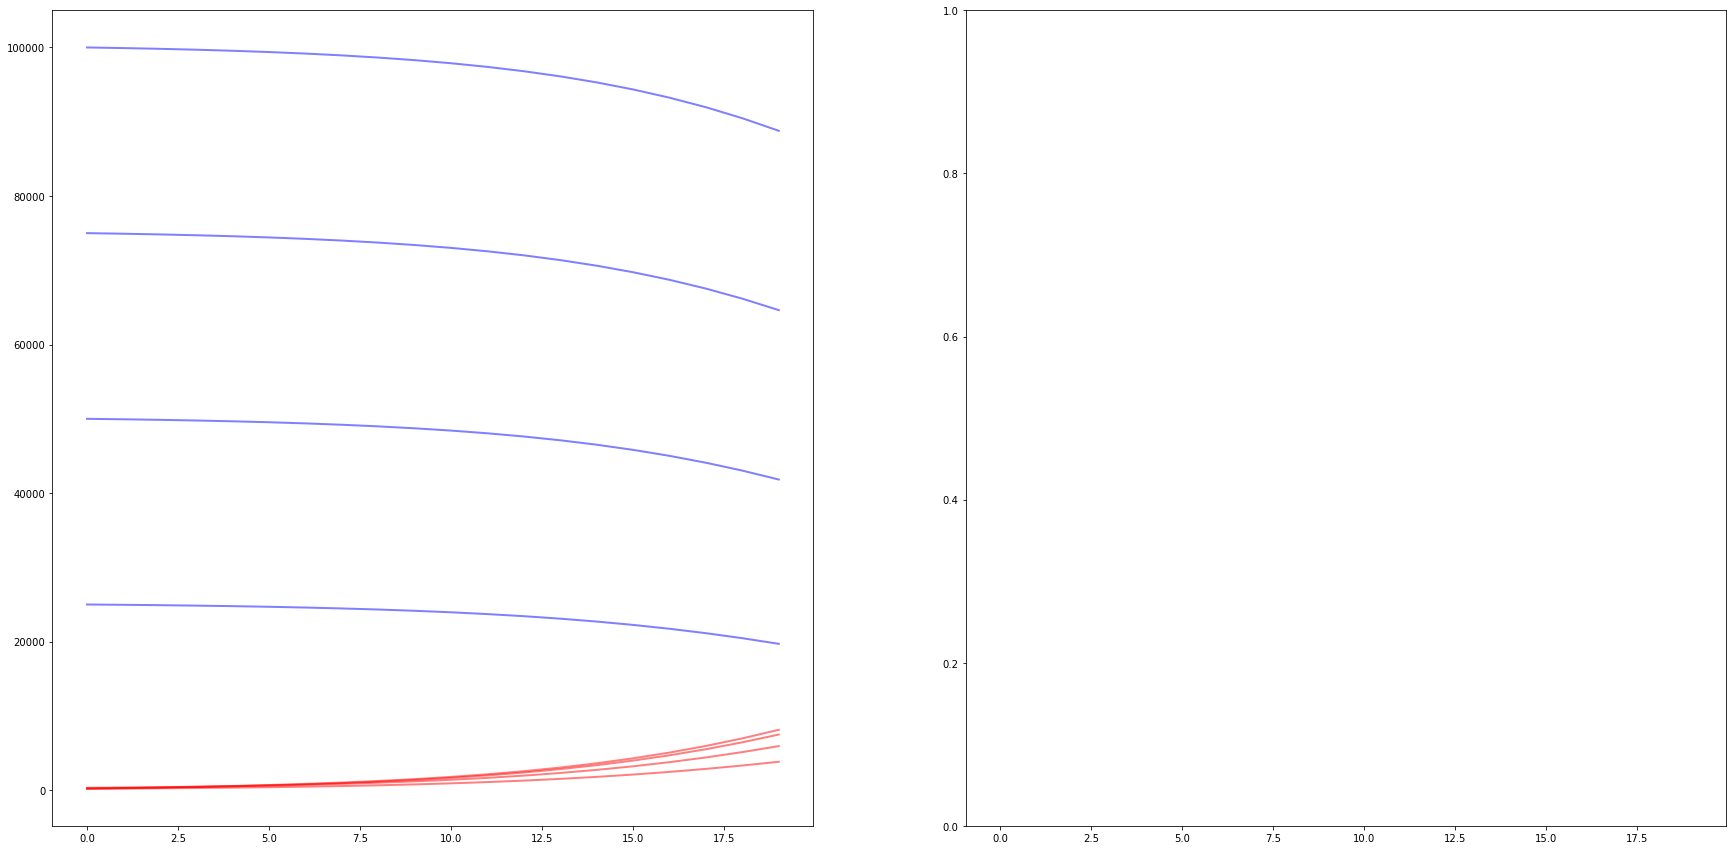

In [30]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (30,15) )
mmse=np.inf
beta_mmse=np.nan
pmf = [0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4]
    
pmf0c = np.array(pmf[4:8])
print(f"PMF of vulnerability 0: {pmf0c}\n")
Sv0, Sv1, Sv2, Sv3 = pmf0c * 50000 * 5
print(f"Sv0 = {Sv0}, Sv1 = {Sv1}, Sv2 = {Sv2}, Sv3 = {Sv3}\n")
print(f"Infected population of first five nodes: Row = node, Column = comorbidity {I_b[0:5]}\n")
I0,I1,I2,I3 = I_b[6:11].sum(axis=0)
print(f"Infected population of first five nodes summed by comorbidity: {I0,I1,I2,I3}\n")
I_five_nodes = np.sum([I0,I1,I2,I3])

beta_grid=np.linspace(0,1,21)
beta_mmse = []
for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
        
    if (betav0 <= betav1 <= betav2 <= betav3):
#         beta = [betav0, betav1, betav2, betav3]
        beta = [0.2 , 0.25, 0.3 , 0.4 ]

        soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                             y0 = (Sv0, Sv1, Sv2, Sv3,
                             I0,I1,I2,I3, 250000), \
                             t_eval = np.arange(20), dense_output = True, \
                             args = (N_b * 5, beta, gamma_b))

        Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, I_nodes = soln_obj.y
        all_S = [Sv0_y, Sv1_y, Sv2_y, Sv3_y]
        for Svc in all_S:
            ax[0].plot(soln_obj.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

        # Plot # Infected vc
        all_I = [I0_y, I1_y, I2_y, I3_y]
        for Ic in all_I:
            ax[0].plot(soln_obj.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')
        print(I0_y)
        print(I1_y)
        print(I2_y)
        print(I3_y)
        L_pred = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
        L_true = np.sum(L_validation[6:11], axis = 0)
        mse = mean_squared_error(L_true, L_pred) 
        
        # If mse is lower, store new value
        if mse < mmse:
            print(f"Searching through beta = {beta}\n")
            print(f"L_sample = {L_sample}\n")
            print(f"L_validation = {L_validation[6:11].sum(axis=0)}\n")
            print(f"MSE = {mse}")
            mmse = mse
            beta_mmse = []
    break

In [26]:
L_validation

array([[  151.15723798,   157.09236032,   166.0663423 ,   175.26894184,
          187.12271809,   200.29536627,   207.19011153,   220.23944915,
          235.52590645,   247.09469931,   263.51055631,   281.18896107,
          304.53407513,   316.7776232 ,   337.4146583 ,   359.08603642,
          376.95873111,   410.63777058,   432.23666001,   466.32640805],
       [  168.20103748,   175.31698233,   184.41546073,   191.23318015,
          200.38958258,   212.84378649,   222.09570163,   237.44506788,
          251.13497681,   263.20329764,   281.12505942,   299.02683147,
          312.07088043,   336.08191882,   353.17466265,   372.3214408 ,
          404.21116271,   424.09816716,   450.52039605,   482.72819186],
       [  108.25555772,   116.61301613,   122.162737  ,   128.61290071,
          136.27974903,   143.16249542,   153.75545994,   158.05373752,
          171.84080869,   178.44468654,   190.6241656 ,   202.74814433,
          214.01601724,   233.09216822,   246.84519371,   265.

2) Now use the “test” data (20 L values for 20 days) from the file and estimate the βv,c. This time you won’t have access to the ground truth βv,c values. Print the βv,c values you estimated.

Answer here

3) Use the βv,c you found to predict the disease behaviour for the future. Solve the equations for 100 days and plot S, I, R, L values for the first node in each social vulnerability case. On L graphs, also plot the corresponding observed values for the first 20 days (with a circle marker).


Answer here